训练数据形状: X_train: (12800, 96, 96), y_train: (12800,)
测试数据形状: X_test: (1600, 96, 96), y_test: (1600,)
训练数据类型: float32
数据范围: 0.0 - 0.99607843


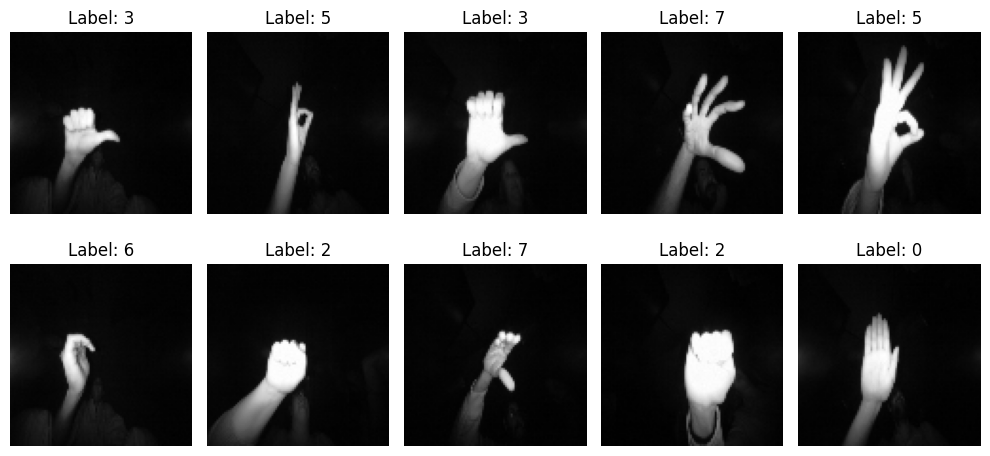

In [1]:
# 首先加载数据集，train.pkl 和 test.pkl 包含了图像数据和标签
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 加载训练数据
def load_data(file_path):
    with open(file_path, 'rb') as f:
        X, y = pickle.load(f)
    return X, y

train_data_path = 'train.pkl'
test_data_path = 'test.pkl'

X_train, y_train = load_data(train_data_path)
X_test, y_test = load_data(test_data_path)

print(f"训练数据形状: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试数据形状: X_test: {X_test.shape}, y_test: {y_test.shape}")

# 确保数据加载正确
print("训练数据类型:", X_train.dtype)  # 通常应为 float32
print("数据范围:", X_train.min(), "-", X_train.max())  # 应为 0-1

# 查看部分数据的图像和标签
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Epoch [1/3], Loss: 0.0876
Epoch [2/3], Loss: 0.0596
Epoch [3/3], Loss: 0.0011
错误分类的样本数量: 6


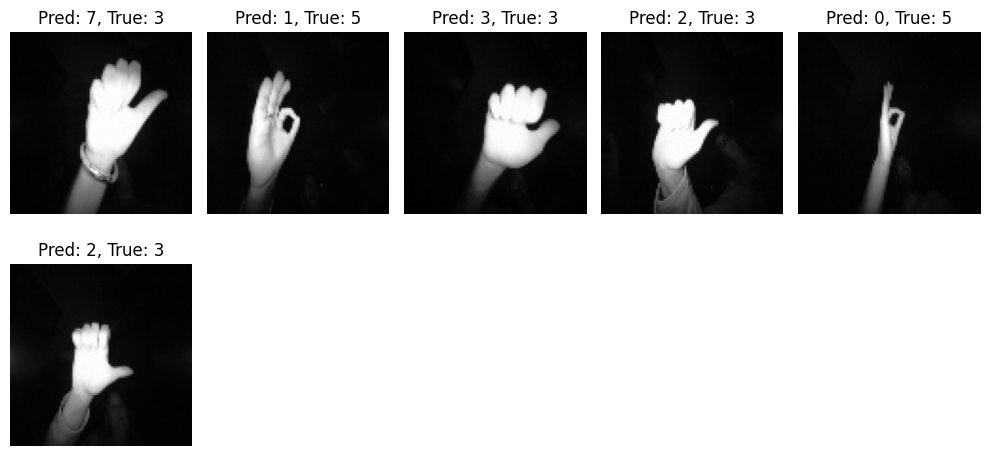

In [2]:
# 1.2 模型辅助标注 - 训练一个简单的模型并查看错误分类的样本
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 24 * 24)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 转换数据为张量
X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# 使用 DataLoader 进行小批量训练
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 定义模型、损失函数和优化器
model = SimpleCNN()

# 使用 GPU (CUDA) 加速训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 简单训练模型（仅训练几轮以获取初步结果）
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 使用 DataLoader 分批获取错误分类的样本
model.eval()
incorrect_indices = []
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        batch_incorrect = (predicted != targets).nonzero(as_tuple=True)[0]
        incorrect_indices.extend(batch_incorrect.cpu().numpy())
        if len(incorrect_indices) >= 10:  # 只获取前10个错误分类样本
            break

print(f"错误分类的样本数量: {len(incorrect_indices)}")

# 显示部分错误分类的样本
plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f'Pred: {predicted[idx].item()}, True: {y_train[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


训练集类别分布:
类别 0: 1600 张图片
类别 1: 1600 张图片
类别 2: 1600 张图片
类别 3: 1600 张图片
类别 4: 1600 张图片
类别 5: 1600 张图片
类别 6: 1600 张图片
类别 7: 1600 张图片


/home/dahao/anaconda3/envs/dl_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dahao/anaconda3/envs/dl_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dahao/anaconda3/envs/dl_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dahao/anaconda3/envs/dl_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dahao/anaconda3/envs/dl_env/lib/python3.11/site-packages/IPython/core/pylabtoo

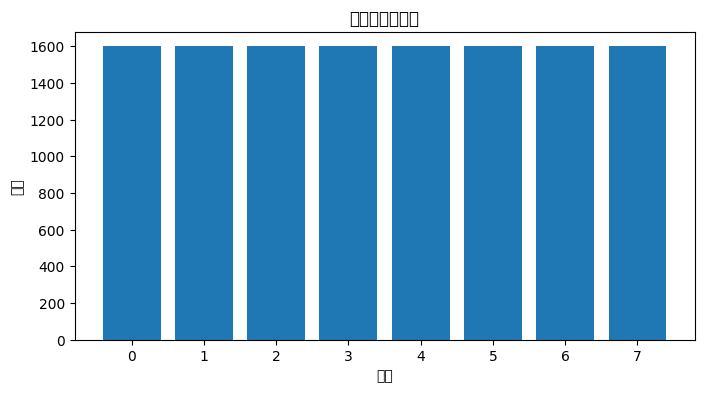

In [3]:
# 1.4 统计分析 - 检查每个类别的数量是否异常
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("\n训练集类别分布:")
for cls, count in class_distribution.items():
    print(f"类别 {cls}: {count} 张图片")

# 可视化类别分布
plt.figure(figsize=(8, 4))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('类别')
plt.ylabel('数量')
plt.title('训练集类别分布')
plt.show()

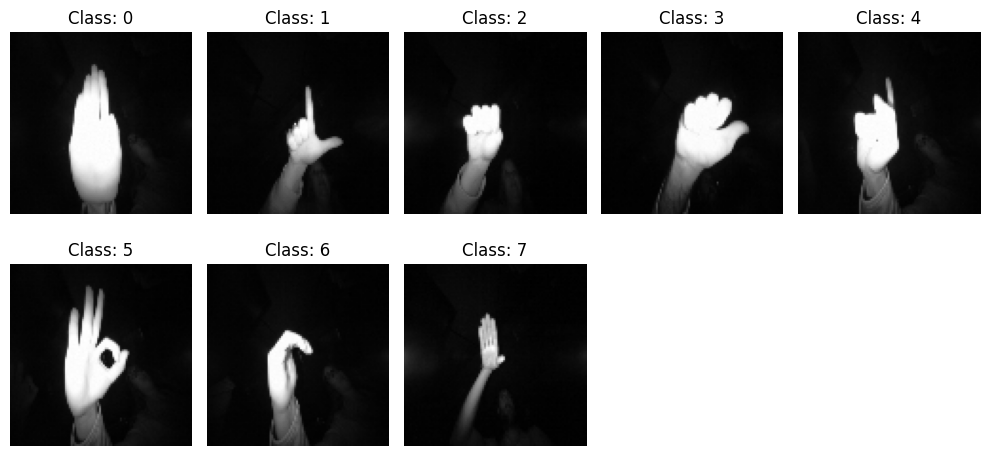

In [5]:
# 从每个类别中随机挑选一张图片进行展示
plt.figure(figsize=(10, 5))
for cls in class_distribution.keys():
    indices = np.where(y_train == cls)[0]
    random_index = np.random.choice(indices)
    plt.subplot(2, 5, cls + 1)
    plt.imshow(X_train[random_index], cmap='gray')
    plt.title(f'Class: {cls}')
    plt.axis('off')
plt.tight_layout()
plt.show()